## Hate Speech and Offesndive Language Detection Using BERT Transformers

Hecho por:
+ Juan Pablo Blanco Lemus
+ Diego Mercado Coello
+ Carlos Alberto Moreno Labrador
+ Carlos Arturo Torres Sánchez

Este proyecto tiene como objetivo construir un clasificador que pueda detectar discursos de odio y lenguaje ofensivo en tweets utilizando modelos Transformer, específicamente BERT. El conjunto de datos proviene de Kaggle y consta de tweets categorizados en tres clases:
+ `Hate Speech (Class 0)`
+ `Offensive Language (Class 1)`
+ `Neither (Class 2)`

El dataset con el que vamos a trabajar tiene las siguientes columnas:
+ `count`: Número de usuarios de CrowdFlower que codificaron cada tweet.
+ `hate_speech`: Número de usuarios que juzgaron el tweet como discurso de odio.
+ `offensive_language`: Número de usuarios que juzgaron el tweet como ofensivo.
+ `neither`: Número de usuarios que juzgaron el tweet como ninguno.
+ `class`: 0 - hate speech, 1 - offensive language, 2 - neither.
+ `tweet`: El texto del tweet.

### Importamos las librerías 

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import kagglehub
import re
from transformers import BertTokenizer

### Carga y preprocesamiento de los datos

In [2]:
path = kagglehub.dataset_download('mrmorj/hate-speech-and-offensive-language-dataset')
df = pd.read_csv(f'{path}/labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [4]:
df.isna().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [5]:
df[['tweet', 'class']].head(100) 

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...
95,"""@CauseWereGuys: Going back to school sucks mo...",1
96,"""@CauseWereGuys: On my way to fuck yo bitch ht...",1
97,"""@CeleyNichole: @white_thunduh how come you ne...",1
98,"""@ChadMFVerbeck: If Richnow doesn't show up wi...",1


#### Limpiamos el dataset

Realizaremos lo siguiente:
+ Quitaremos los espacios que se encuentran al principio y al final de tweet.
+ Eliminaremos las URLs
+ Eliminaremos las menciones a otros usuarios.

In [6]:
def clean_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [7]:
df['clean_tweet'] = df['tweet'].apply(clean_text)
df[['tweet','clean_tweet']].head(100)

,tweet,clean_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT : she look like a tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...
...,...,...
95,"""@CauseWereGuys: Going back to school sucks mo...",""": Going back to school sucks more dick than t..."
96,"""@CauseWereGuys: On my way to fuck yo bitch ht...",""": On my way to fuck yo bitch me as a 9 year old"
97,"""@CeleyNichole: @white_thunduh how come you ne...",""": how come you never bring me food"" i dont ha..."
98,"""@ChadMFVerbeck: If Richnow doesn't show up wi...",""": If Richnow doesn't show up with hella tinde..."


In [8]:
# Inicializamos el tokenizador
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [9]:
# Encodeamos el texto
encoded_data = tokenizer(
    df['clean_tweet'].tolist(),
    add_special_tokens=True,
    truncation=True,
    padding='max_length',
    max_length=64,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = df['class']

### Separación del Dataset en train y test

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

# Creamos el dataset
dataset = TensorDataset(input_ids, attention_masks, torch.tensor(labels.values))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

### Inicializamos el modelo

In [11]:
from transformers import BertForSequenceClassification, AdamW

# Load BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Entrenamos el modelo

In [12]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Training loop
from transformers import get_linear_schedule_with_warmup

epochs = 4
total_steps = len(train_dataloader) * epochs

# Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training function
import numpy as np
from sklearn.metrics import accuracy_score
import time

def train(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(dataloader):
        # Progress update
        if step % 40 == 0 and not step == 0:
            print(f'  Batch {step} of {len(dataloader)}.')

        # Move batch to device
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        # Clear gradients
        model.zero_grad()

        # Forward pass
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Average training loss: {avg_loss}')

# Start training
for epoch_i in range(epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    train(model, train_dataloader, optimizer, scheduler)

/Users/juanpabloblanco/Documents/Machine Learning/BERT_and_Transformers/.venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 4 ========
  Batch 40 of 620.
  Batch 80 of 620.
  Batch 120 of 620.
  Batch 160 of 620.
  Batch 200 of 620.
  Batch 240 of 620.
  Batch 280 of 620.
  Batch 320 of 620.
  Batch 360 of 620.
  Batch 400 of 620.
  Batch 440 of 620.
  Batch 480 of 620.
  Batch 520 of 620.
  Batch 560 of 620.
  Batch 600 of 620.
Average training loss: 0.3986045311535558
======== Epoch 2 / 4 ========
  Batch 40 of 620.
  Batch 80 of 620.
  Batch 120 of 620.
  Batch 160 of 620.
  Batch 200 of 620.
  Batch 240 of 620.
  Batch 280 of 620.
  Batch 320 of 620.
  Batch 360 of 620.
  Batch 400 of 620.
  Batch 440 of 620.
  Batch 480 of 620.
  Batch 520 of 620.
  Batch 560 of 620.
  Batch 600 of 620.
Average training loss: 0.28092124195949686
======== Epoch 3 / 4 ========
  Batch 40 of 620.
  Batch 80 of 620.
  Batch 120 of 620.
  Batch 160 of 620.
  Batch 200 of 620.
  Batch 240 of 620.
  Batch 280 of 620.
  Batch 320 of 620.
  Batch 360 of 620.
  Batch 400 of 620.
  Batch 440 of 620.
  Batch 480

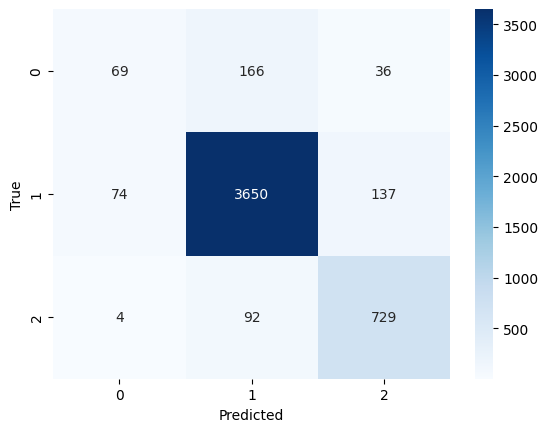

                    precision    recall  f1-score   support

       Hate Speech       0.47      0.25      0.33       271
Offensive Language       0.93      0.95      0.94      3861
           Neither       0.81      0.88      0.84       825

          accuracy                           0.90      4957
         macro avg       0.74      0.69      0.70      4957
      weighted avg       0.89      0.90      0.89      4957



In [13]:
def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask
            )

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

    return predictions, true_labels

# Get predictions
preds, true = evaluate(model, test_dataloader)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(true, preds, target_names=['Hate Speech', 'Offensive Language', 'Neither']))

In [14]:
# Después del ciclo de entrenamiento
model.save_pretrained('hate_speech_model')
tokenizer.save_pretrained('hate_speech_model')

('hate_speech_model/tokenizer_config.json',
 'hate_speech_model/special_tokens_map.json',
 'hate_speech_model/vocab.txt',
 'hate_speech_model/added_tokens.json')

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Ruta donde guardaste el modelo
modelo_path = 'hate_speech_model'

# Cargar el tokenizador
tokenizer = BertTokenizer.from_pretrained(modelo_path)

# Cargar el modelo
model = BertForSequenceClassification.from_pretrained(modelo_path)

# Mover el modelo al dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
def clean_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [17]:
def tokenize_text(text, tokenizer, max_length=64):
    return tokenizer(
        text,
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_attention_mask=True,
        return_tensors='pt'
    )

In [18]:
def classify_text(text, model, tokenizer, device):
    # Preprocesar el texto
    clean = clean_text(text)
    
    # Tokenizar el texto
    tokens = tokenize_text(clean, tokenizer)
    
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    
    # Realizar la predicción
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).cpu().item()
    
    # Mapeo de las clases
    class_mapping = {
        0: 'Hate Speech',
        1: 'Offensive Language',
        2: 'Neither'
    }
    
    return class_mapping.get(predicted_class, 'Unknown')

In [21]:
# Texto de ejemplo
texto_ejemplo = "Fucking psycopath, kill yourself"

# Clasificar el texto
clasificacion = classify_text(texto_ejemplo, model, tokenizer, device)

print(f"El texto se clasifica como: {clasificacion}")

El texto se clasifica como: Hate Speech


### Pruebas

In [24]:
def main():
    print("Detector de Hate Speech y Lenguaje Ofensivo")
    print("Escribe 'salir' para terminar.\n")
    
    while True:
        texto = input("Introduce un texto: ")
        if texto.lower() == 'salir':
            break
        clasificacion = classify_text(texto, model, tokenizer, device)
        print(f"Clasificación: {clasificacion}\n")

if __name__ == "__main__":
    main()

Detector de Hate Speech y Lenguaje Ofensivo
Escribe 'salir' para terminar.

Clasificación: Hate Speech

